# 详解大模型并行化训练

## basics pf networking for LLMs
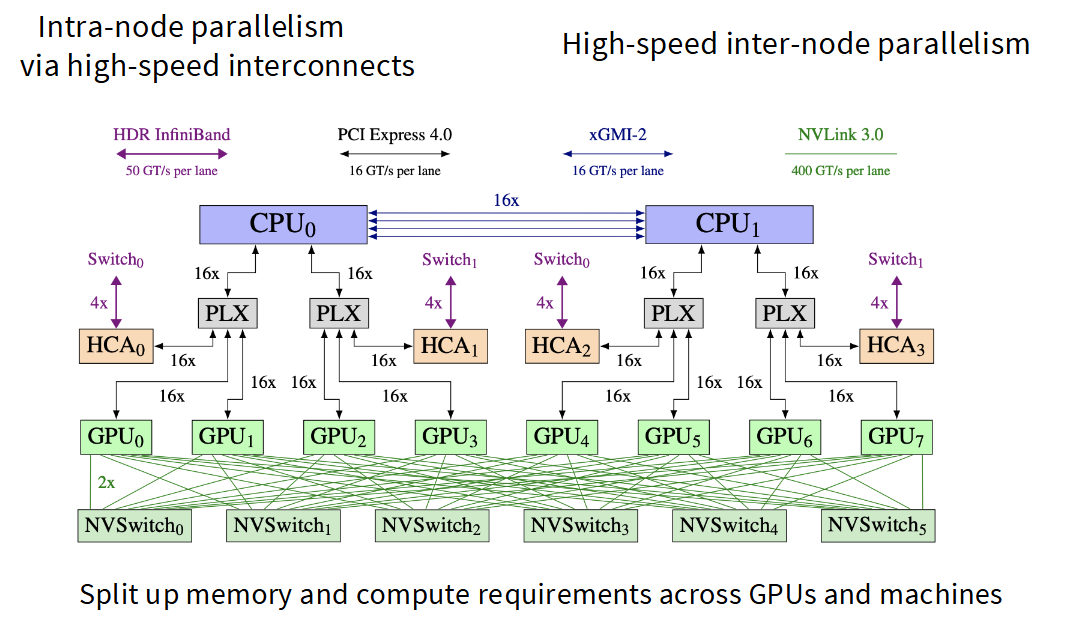NVLink 3.0的传输速度是最快的，达到每条线400 GT/s。它主要用于GPU之间的连接，提供非常高的数据带宽，适用于需要大规模并行计算的任务，能够有效地支持GPU间的大量数据传输。

相比之下：

HDR Infiniband 的传输速度为每条线50 GT/s，主要用于不同计算节点之间的通信，尽管非常快，但比NVLink要慢。

PCI Express 4.0 的速度为每条线16 GT/s，主要用于单节点内的CPU和GPU之间的数据传输，传输速度较低。

xGMI-2 和 Switch 都有16 GT/s的带宽，主要用于节点间的连接，但速度不及NVLink和HDR Infiniband。

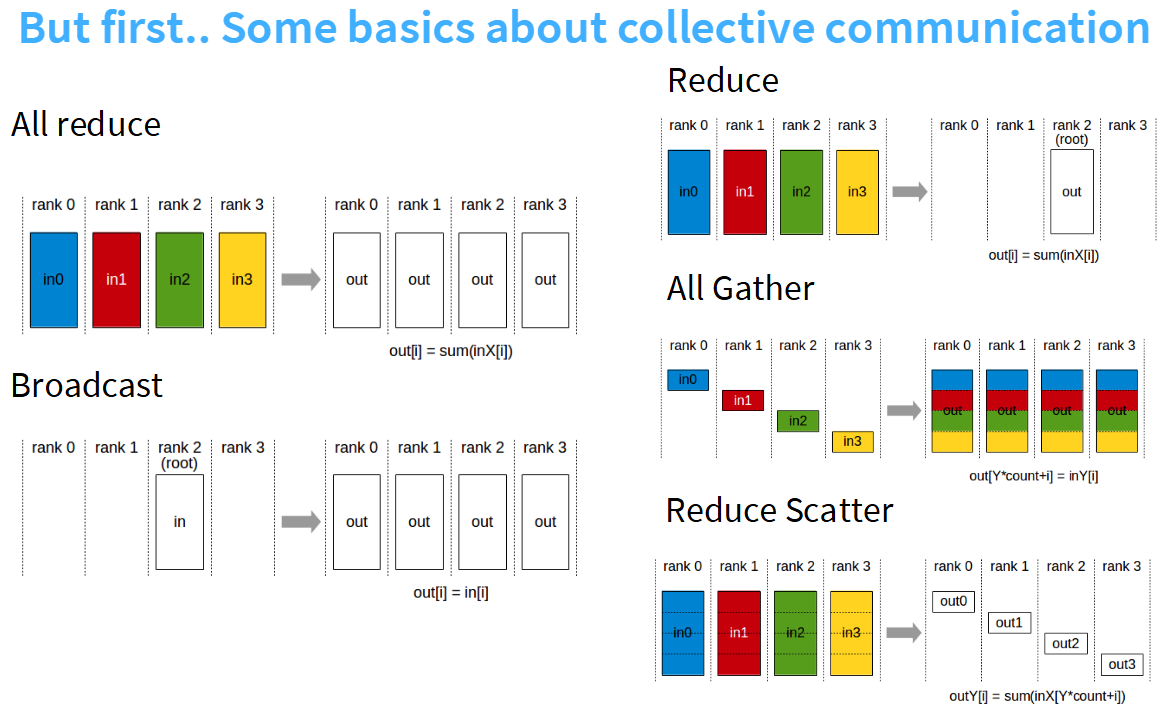
**在这里可以把每个计算节点当成是一个机器,后面的括号是通信开销**
**All reduce（2x）**：

每个计算节点（rank 0 到 rank 3）都有一个输入数据（in0, in1, in2, in3）。

所有节点的数据会被汇总并合并成一个输出结果（out）。例如，out[i] = sum(inX[i])，意味着所有节点的输入数据会被相加并返回，复制结果给每个节点。

**Broadcast(1x)**：

在此操作中，节点 2（root）有一个输入数据（in），它会广播给其他所有节点（rank 0, rank 1, rank 3）。所以所有节点都会收到相同的数据。

例如，out[i] = in[i]，每个节点的输出数据等于根节点（root）的输入数据。

**Reduce**：

参与者（rank 0 到 rank 3）都有自己的输入数据（in0, in1, in2, in3）。
然后，所有这些输入数据会通过某种“归约”操作（如求和、最大值、最小值等）进行合并。这里的示例是对所有输入数据进行加法：out[i] = sum(inX[i])。

最终，所有节点的数据被合并成一个输出结果（out），并且结果只会保留在一个节点上，通常是指定的根节点（例如，rank 2）。

**All Gather**：

在 All Gather 操作中，每个节点（rank 0 到 rank 3）都有自己的输入数据（in0 到 in3），这些数据每一个都会广播到所有的输出节点上。

例如，out[Y*count + i] = inY[i]，这意味着每个节点将收集所有其他节点的数据，形成一个合并后的输出结果。

**Reduce Scatter**：

该操作将总数据进行分散，每个节点只会获得一部分结果。各个节点的输入数据（in0 到 in3）的每一行会经过合并处理，然后输出到每个节点。

例如，outY[i] = sum(inX[i*count])，每个节点都会计算一部分汇总的结果。

**左右两个的性能一致**
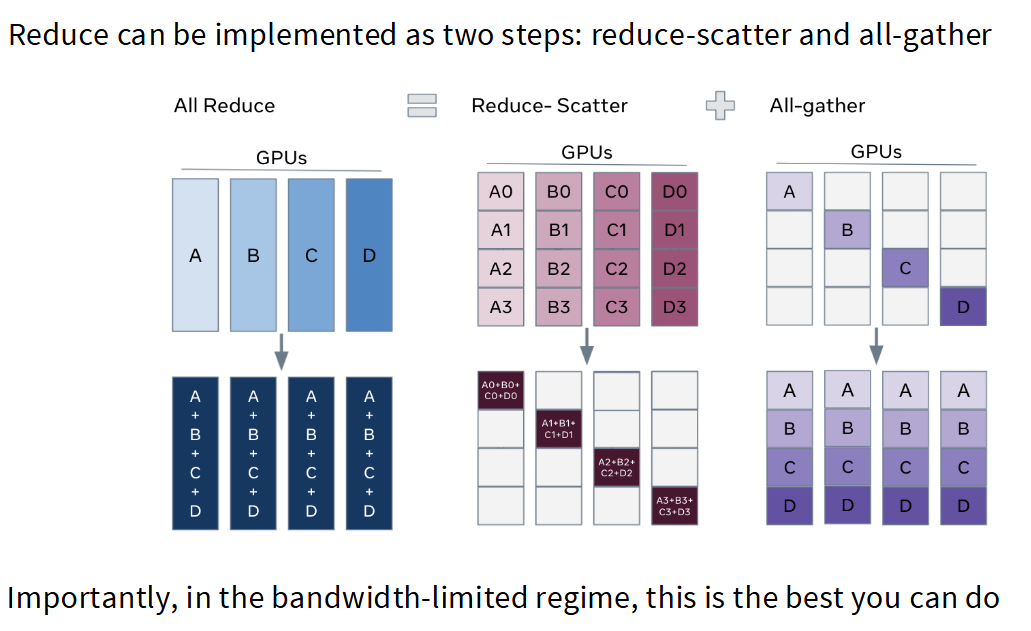

### TPUs vs GPUs – design differences at the comm level
如何把各个组件链接起来

**GPU在256个内核下都可以进行全连接（把通信成本降到最低），但是超过256就不行了**
**TPU的每个chip都与邻居相来连接**
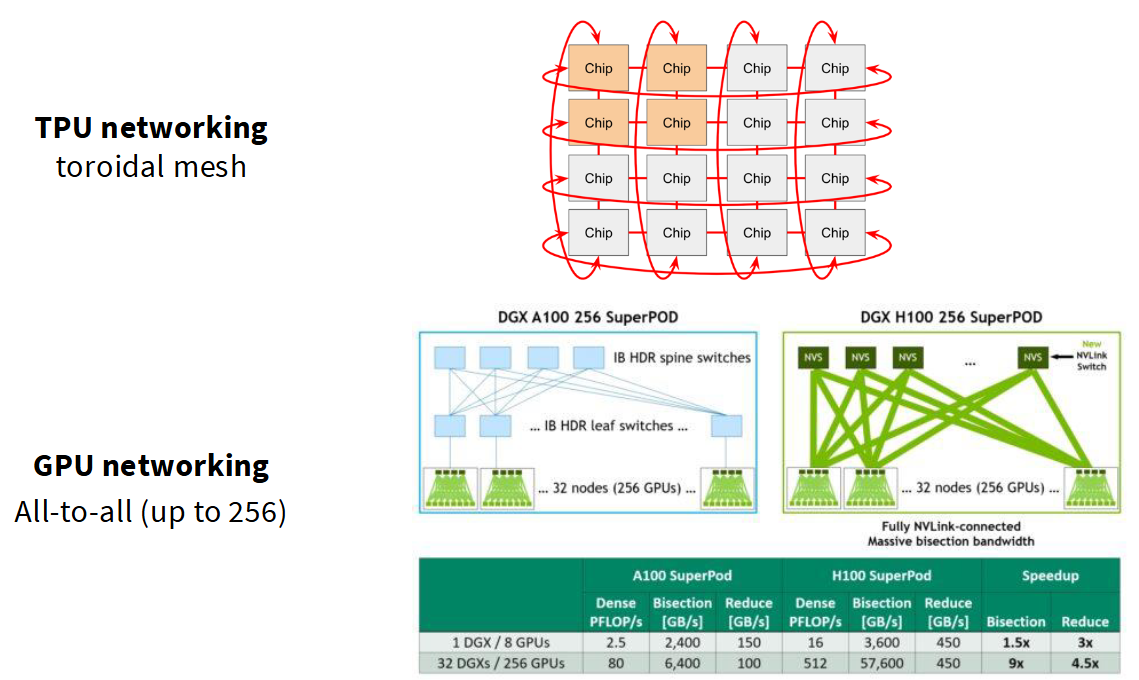

## standard LLM parallelization primitives
**三种并行化方法**
 - Data parallelism
 - Model parallelism(切分模型)
 - Activation parallelism

### Data parallelism

在SGD中，更新模型参数𝜃的过程。每一步通过所有样本的梯度进行累加，然后乘以学习率𝜂来更新参数。
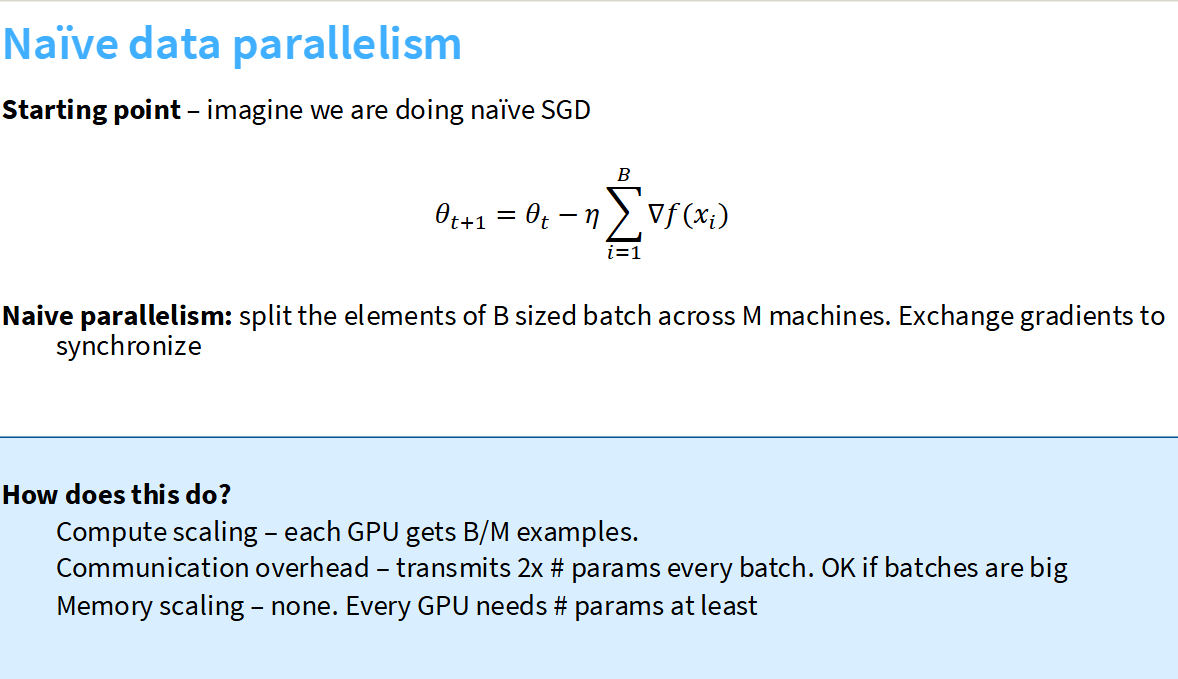

朴素数据并行性（Naïve Data Parallelism）在SGD中的应用：

数据分割：将批次 
𝐵分成𝑀部分，每台机器（或GPU）处理 𝐵/𝑀个样本。

计算扩展：每台GPU计算一部分数据，分担计算任务。

通信开销：每个批次需要传输2倍的参数（计算梯度并同步），大批次时较为合适。

内存扩展：**每台GPU至少需要存储完整模型参数**。

**问题**
Our memory situation is actually terrible.
Depending  on our precision.. 
 - We need 5 copies of weights and 16 bytes per param!


### ZeRO:分片操作
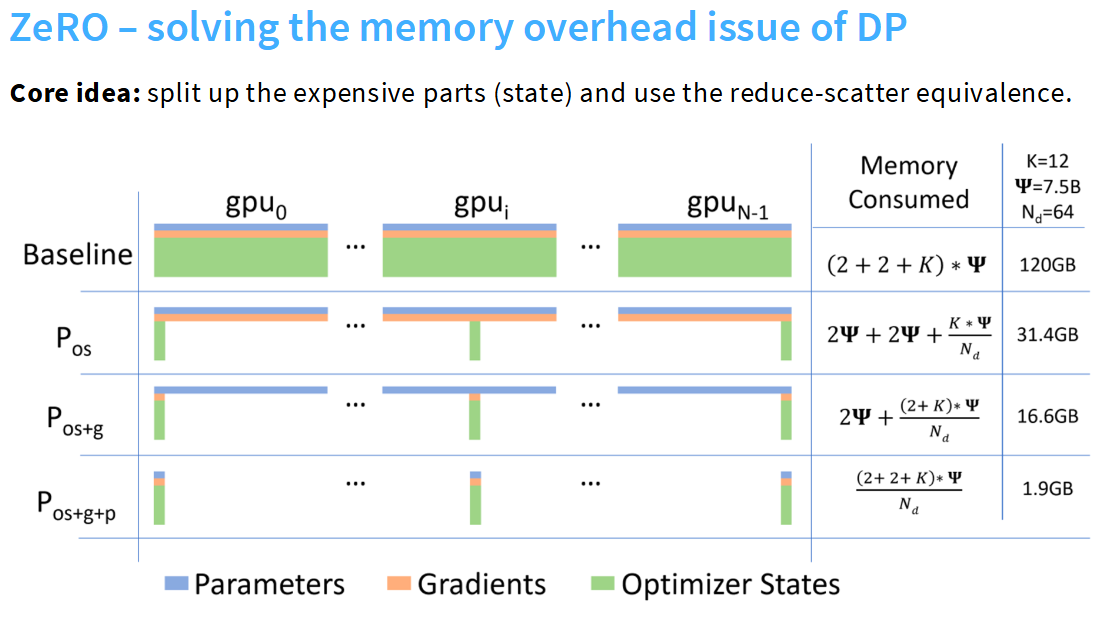
模型训练中的内存状态
在训练一个大型深度学习模型时，一个模型的状态（Model State）主要由三部分组成：

Parameters（参数）: 模型的权重。

Gradients（梯度）: 用于更新参数的梯度，在反向传播时计算得到。

Optimizer States（优化器状态）: 这部分通常是内存消耗的大头。例如，对于Adam优化器，每个参数都需要存储两个额外的状态（一阶矩和二阶矩），因此优化器状态的内存通常是参数内存的两倍。

ZeRO如何工作
图片中展示了三种不同的ZeRO阶段，每一种都比前一个更进一步地减少内存开销。

1. Baseline (DP)
含义: 这是传统的**数据并行(Data Parallelism, DP)**训练模式。

内存开销: 每台GPU（GPU 
0
​
 ,…,GPU 
N−1
​
 ）上都完整地复制了模型的所有参数、梯度和优化器状态。

公式: (2+2+K)×Ψ

Ψ: 每个参数所需的内存（例如，如果使用FP32，Ψ=4字节）。

2Ψ: 优化器状态（例如Adam，需要两倍参数内存）。

2Ψ: 梯度。

K: 参数。

结果: 图片中显示，对于一个N 
d
​
 =64的GPU集群，当模型参数$\Psi=7.5B$时，总内存消耗达到120 GB。这表明传统的DP模式会很快遇到单GPU内存不足的问题。

2. P 
os
​
  (Optimizer States Partitioning)
含义: 这是ZeRO的第一阶段（ZeRO-Stage 1），只对优化器状态进行分片（Partitioning）。

工作原理: 每台GPU只保存全部优化器状态的1/N 
d
​
 部分。而参数和梯度仍然是全量复制的。

内存开销: 每台GPU上：

参数: 全量复制，内存为2Ψ。

梯度: 全量复制，内存为2Ψ。

优化器状态: 分片存储，内存为$\frac{K \cdot \Psi}{N_d}$。

公式: 2Ψ+2Ψ+ $\frac{K \cdot \Psi}{N_d}$

结果: 内存消耗显著降低至31.4 GB。

3. P 
os+g
​
  (Optimizer States + Gradients Partitioning)
含义: 这是ZeRO的第二阶段（ZeRO-Stage 2），同时对优化器状态和梯度进行分片。

工作原理: 每台GPU只保存全部优化器状态的1/N 
d
​
 和全部梯度的1/N 
d
​
 。参数仍然是全量复制的。在反向传播结束后，需要通过AllReduce操作来同步梯度。

内存开销: 每台GPU上：

参数: 全量复制，内存为2Ψ。

梯度: 分片存储，内存为$\frac{2\Psi}{N_d}$。

优化器状态: 分片存储，内存为$\frac{2\Psi}{N_d}$。

公式: 2Ψ+ 
N 
d
​
 
(2+K)⋅Ψ
​
 

结果: 内存消耗进一步降低至16.6 GB。

4. P 
os+g+p
​
  (Optimizer States + Gradients + Parameters Partitioning)
含义: 这是ZeRO的第三阶段（ZeRO-Stage 3），对**所有三部分（参数、梯度和优化器状态）**都进行分片。

工作原理: 每台GPU只保存模型状态的1/N 
d
​
 。在前向或反向传播时，需要通过reduce-scatter或all-gather等操作，动态地将需要的参数从其他GPU上“收集”过来。

内存开销: 每台GPU上只存储模型的1/N 
d
​
 。

公式:  
N 
d
​
 
(2+2+K)⋅Ψ
​
 

结果: 内存消耗降至最低，仅为1.9 GB。这使得在单个GPU上训练原本需要120GB内存的大模型成为可能。

**图中y轴代表的是数据量**
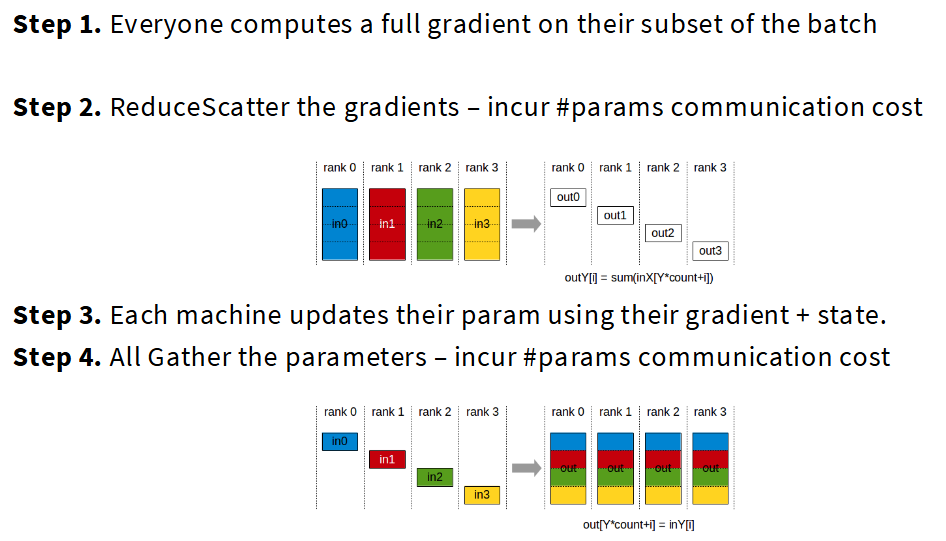

ZeRO Stage 1: 优化器状态分片
ZeRO Stage 1 的核心思想是只对优化器状态进行分片。

步骤 1: 计算完整梯度。每个GPU（rank 0 到 rank 3）都处理自己的那部分数据批次（Data Subset），并像传统的数据并行一样，计算模型的完整梯度。此时，每个GPU上都有一份完整的参数（in0, in1, in2, in3），梯度和优化器状态。

步骤 2: Reduce-Scatter 梯度。计算完梯度后，所有GPU会通过 ReduceScatter 操作来分发梯度。每个GPU只保留并汇总其负责更新的那部分参数对应的梯度。例如，rank 0 只保留 in0 的梯度，rank 1 只保留 in1 的梯度，以此类推。这一步产生了与模型参数量成正比的通信开销。

步骤 3: 更新本地参数。每个GPU使用它本地保存的完整参数、本地分片的优化器状态，以及分片后的梯度来更新其负责的那部分参数。

步骤 4: All-Gather 参数。完成参数更新后，为了准备下一轮的前向传播，所有GPU需要通过 All-Gather 操作将所有更新后的参数同步回每个GPU，确保每个GPU上都有一个完整的、一致的参数副本。

总结: ZeRO Stage 1 通过分片优化器状态来节省内存，但参数和梯度仍需要全量存储和传输，这导致了较高的通信开销。

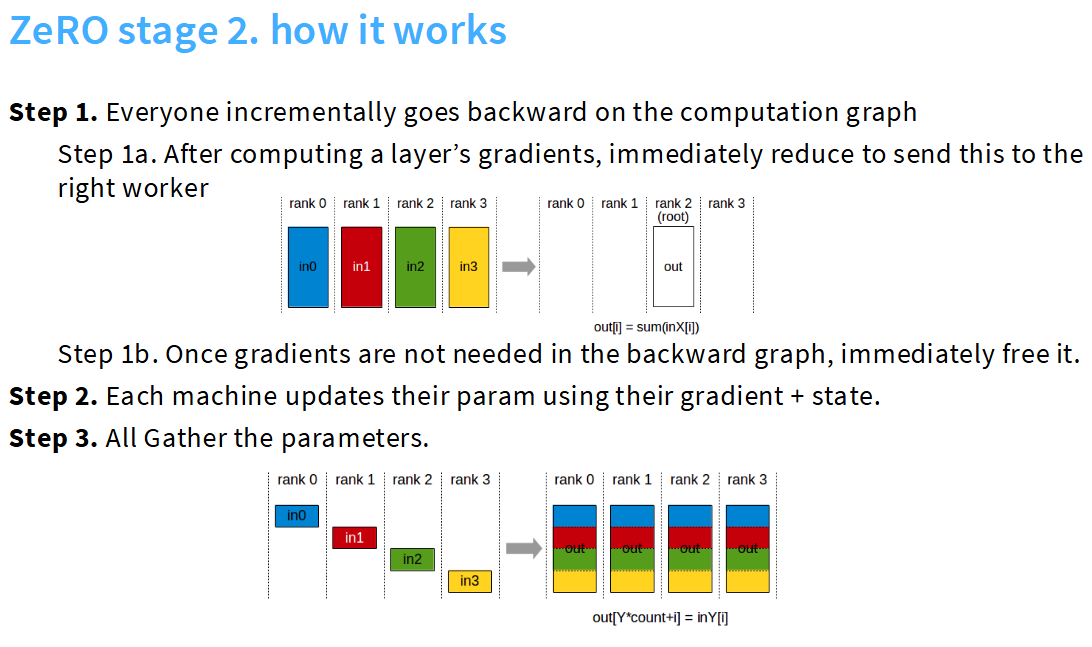ZeRO Stage 2: 梯度和优化器状态分片
ZeRO Stage 2 进一步优化，它将梯度和优化器状态都进行了分片，以节省更多内存。

步骤 1: 增量反向传播和梯度分发。在反向传播过程中，每计算出一个层的梯度，就立即通过 Reduce 操作将其发送到负责该层参数更新的GPU上。这个过程是增量的，可以边计算边通信。一旦梯度不再需要，就立即释放其内存。

步骤 2: 更新本地参数。每个GPU使用其本地分片的梯度和优化器状态来更新自己负责的那部分参数。

步骤 3: All-Gather 参数。完成参数更新后，所有GPU通过 All-Gather 操作将更新后的参数同步回来，确保每个GPU上都有一个完整的、一致的参数副本，为下一轮的前向传播做准备。

总结: ZeRO Stage 2 在 Stage 1 的基础上，进一步分片了梯度，显著降低了内存消耗，但依然需要 All-Gather 来同步完整的参数，因此通信开销仍然不小。

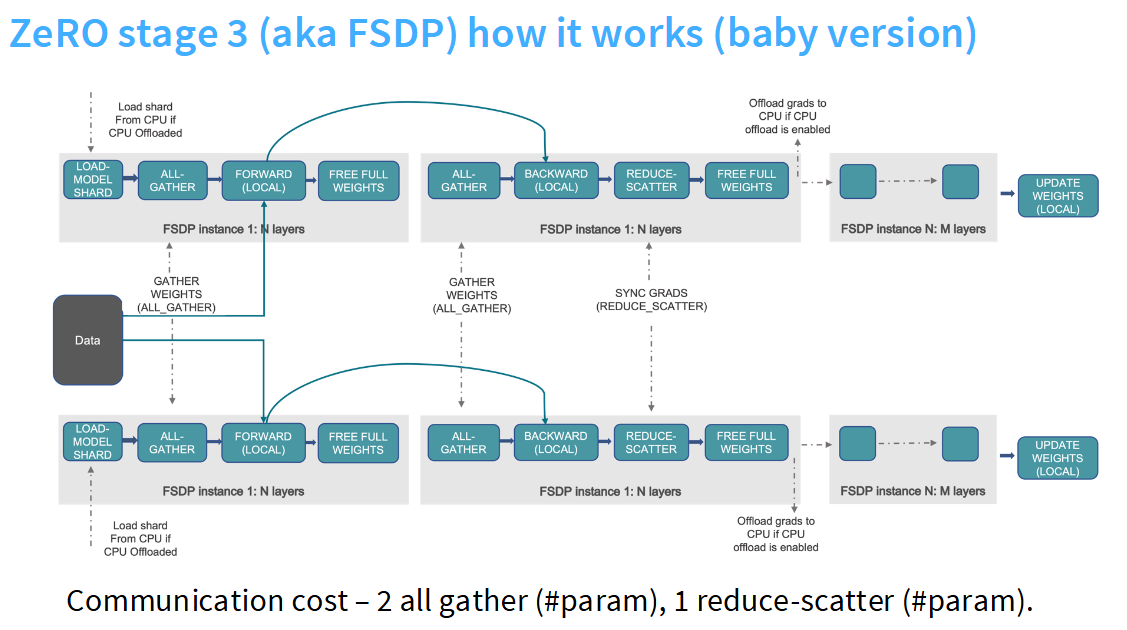ZeRO Stage 3 (FSDP): 参数、梯度和优化器状态分片
ZeRO Stage 3，也常被称为FSDP (Fully Sharded Data Parallelism)，是最高级别的内存优化。它将**所有模型状态（参数、梯度、优化器状态）**都进行了分片。

**前向传播**:

加载分片: 在开始计算之前，每个GPU只加载它自己负责的参数分片。

All-Gather: 为了进行某一层的前向计算，每个GPU需要通过 All-Gather 操作从其他GPU上“收集”该层的所有参数，形成完整的权重矩阵。

前向计算: 在本地进行该层的前向计算。

释放完整权重: 一旦该层的计算完成，之前 All-Gather 得到的完整权重就可以立即释放内存了。这个过程是流式的，对每一层重复进行。

**反向传播**:

All-Gather: 类似地，在进行某一层反向传播时，需要通过 All-Gather 来获取完整的权重。

反向计算: 在本地进行反向传播，计算出该层的梯度。

Reduce-Scatter: 计算完梯度后，通过 Reduce-Scatter 操作将梯度发送到其对应的参数所在的GPU上，并进行汇总。

释放完整权重: 梯度计算完成后，完整权重可以立即释放内存。

**更新参数**:

在反向传播结束后，每个GPU已经收到了其负责的参数对应的所有梯度，可以直接用本地的优化器状态进行参数更新。

通信开销: 图片下方明确指出，一次完整的训练迭代（前向+反向）的通信开销是 2 次 All-Gather 和 1 次 Reduce-Scatter，这些操作都与参数量成正比。

### Actual picture of how FDSP / ZeRO stage 3 works
虽然看上去参数会不停的交换会带来很多的性能损失，但是由于可以在计算的过程中可以实现所有的参数交换，所以对性能的影响并不大，**在进行矩阵计算的时候就加载下一个阶段的参数**
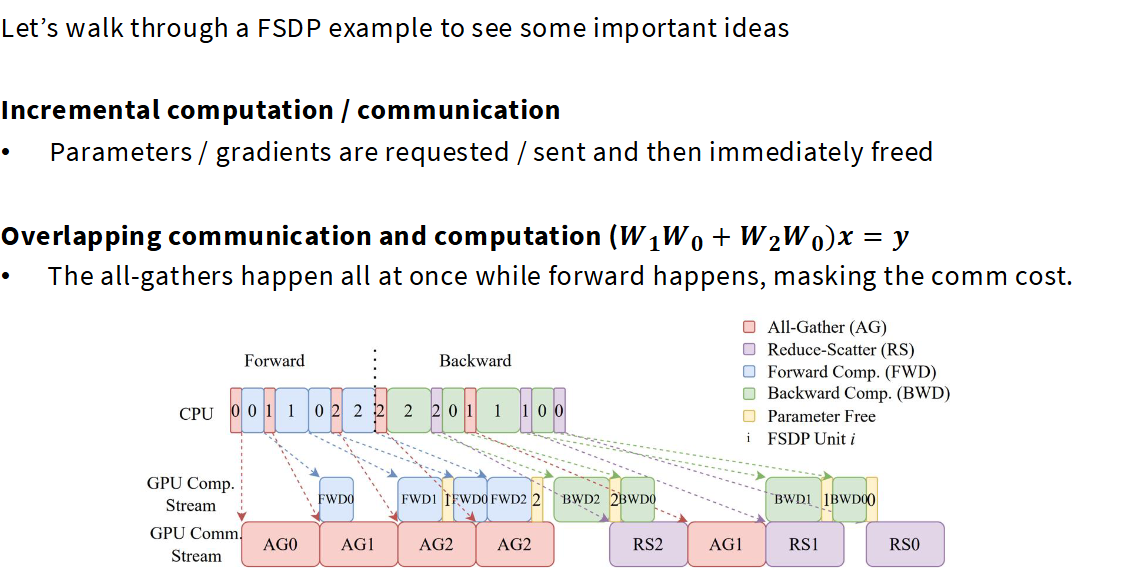
FSDP（ZeRO Stage 3）工作原理更深入的解释，它展示了FSDP如何通过增量计算和计算与通信重叠这两个关键思想来优化性能。

1. 增量计算与通信（Incremental computation / communication）
核心思想: “即用即取，用完即弃”。

具体表现: 在前向和反向传播过程中，FSDP 不会一次性获取所有参数。相反，它**逐层（Layer-by-Layer）**进行操作。

前向传播: FSDP 在开始计算某一层（比如 FSDP Unit 0）时，会通过 All-Gather 操作获取这一层的完整权重，进行计算，然后立即释放这些权重，再对下一层重复此过程。

反向传播: 反向传播过程也是一样的，逐层获取权重、计算梯度，然后将梯度通过 Reduce-Scatter 发送到对应的 GPU 上，并立即释放权重。

这种方式最大限度地减少了在任何给定时间点 GPU 显存中存储的权重总量，从而实现了极大的内存节省。

2. 计算与通信重叠（Overlapping communication and computation）
这是 FSDP 能够高效运行的关键优化，它解决了通信（通过网络传输数据）可能成为瓶颈的问题。

核心思想: FSDP 将计算任务和通信任务在时间上进行重叠，用计算时间来掩盖通信时间。

具体表现:

前向传播（Forward Pass）: 如图所示，当 GPU 计算当前层（FWD0）时，它会并行地在另一个流（GPU Comm. Stream）上启动下一层（AG1）的 All-Gather 通信操作。

反向传播（Backward Pass）: 同样，在进行当前层（BWD2）的反向计算时，GPU 会同时启动上游层（RS2）的 Reduce-Scatter 通信操作。

通过这种方式，当一个 GPU 忙于计算时，另一个 GPU 已经在为它准备下一轮的所需数据。理想情况下，All-Gather 和 Reduce-Scatter 的通信时间会被计算时间完全“隐藏”起来，从而使得整个训练过程的吞吐量（Throughput）得到最大化。

### Zero的通信消耗
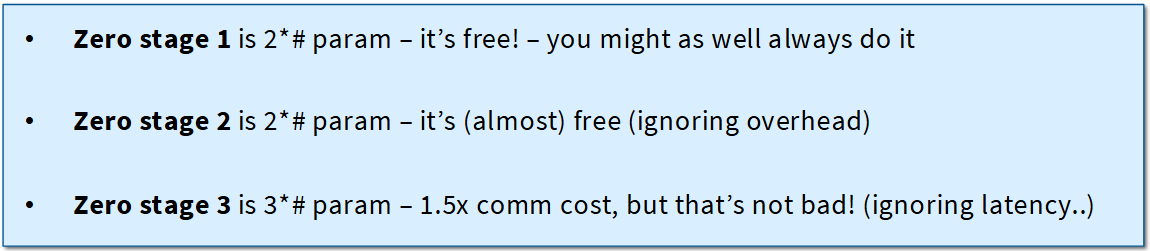
就算是stage3做完之后，也只是消耗了1.5x的时间

### ZeRO的挑战
第一个问题：计算扩展性（Compute Scaling）
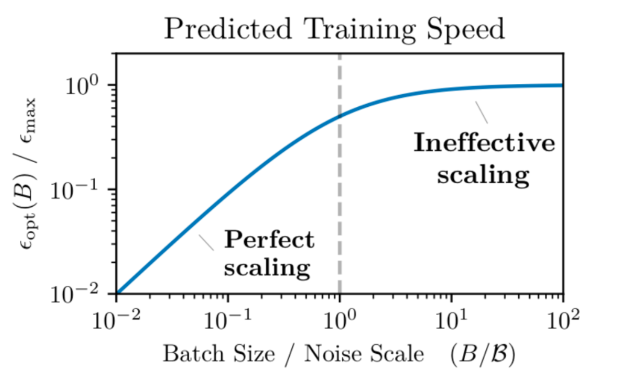
核心论点: 当使用数据并行时，#machines < batch size（机器数量小于批次大小）时，通信开销很高，而且增加批次大小会遇到边际效益递减。

图示解释:

X轴 (Batch Size): 表示批次大小。

Y轴 (Predicted Training Speed): 表示预测的训练速度，即每秒钟的有效计算量。

“Perfect scaling” 完美扩展: 在曲线的左半部分，训练速度随着批次大小的增加而线性增长。这意味着你用更多的机器（更大的批次）就能获得更高的计算效率。

“Ineffective scaling” 无效扩展: 在曲线的右半部分，当批次大小超过某个临界点（图中虚线所示）后，即使你继续增加批次大小，训练速度的提升也变得微乎其微，甚至可能下降。

原因: 随着批次大小的增加，GPU之间需要同步的梯度数据量也增加，导致通信开销越来越大。最终，通信时间会主导整个训练过程，使得增加机器或批次大小带来的计算收益被通信延迟所抵消。

第二个问题：模型不匹配（Models Don't Fit）
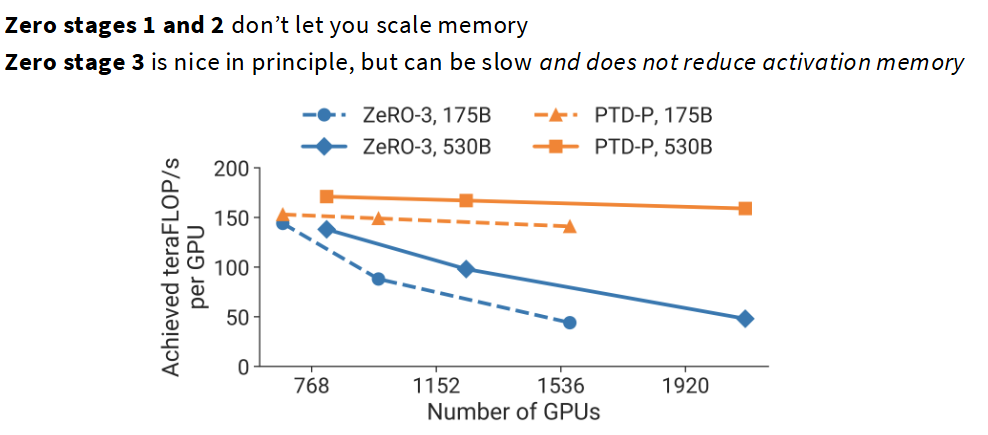
核心论点: ZeRO Stage 1 和 2 无法解决根本的内存扩展性问题。即使是 ZeRO Stage 3 (FSDP)，在某些情况下也可能变慢，并且不能减少**激活值（activations）**的内存消耗。

图示解释:

X轴 (Number of GPUs): 表示使用的GPU数量。

Y轴 (Achieved teraFLOPS per GPU): 表示每个GPU实际达到的计算能力。这是一个衡量训练效率的指标，值越高越好。

ZeRO-3, 175B: 使用 ZeRO Stage 3 训练一个175亿参数的模型。随着GPU数量增加，每个GPU的计算效率（吞吐量）显著下降。

PTD-P, 175B: 使用**流水线并行（Pipeline Parallelism）**训练同样规模的模型，其效率下降趋势比 ZeRO-3 平缓得多。

## Model parallelism
 - 不改变批次大小
 - 在GPU之间不传递参数而是传递激活值
 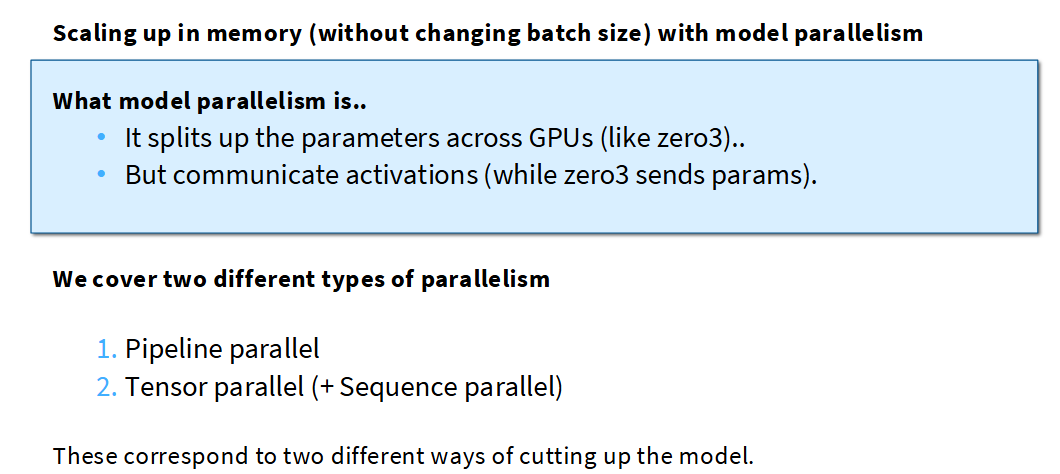

激活值是指在神经网络的前向传播过程中，每一层的神经元在经过激活函数（如 ReLU, GELU, Tanh 等）计算后输出的中间结果。

简单来说，当数据流经一个神经网络时：
输入数据→第1层线性变换→激活函数→激活值1
激活值1→第2层线性变换→激活函数→激活值2
...

这些中间计算结果就是激活值。

为什么激活值会占用大量显存？
在模型训练过程中，为了进行反向传播（即计算梯度并更新参数），我们需要这些激活值。梯度计算是一个链式法则（chain rule）的过程，它需要利用前向传播时每一层的激活值来计算当前层的梯度。

### layer-wise parallel
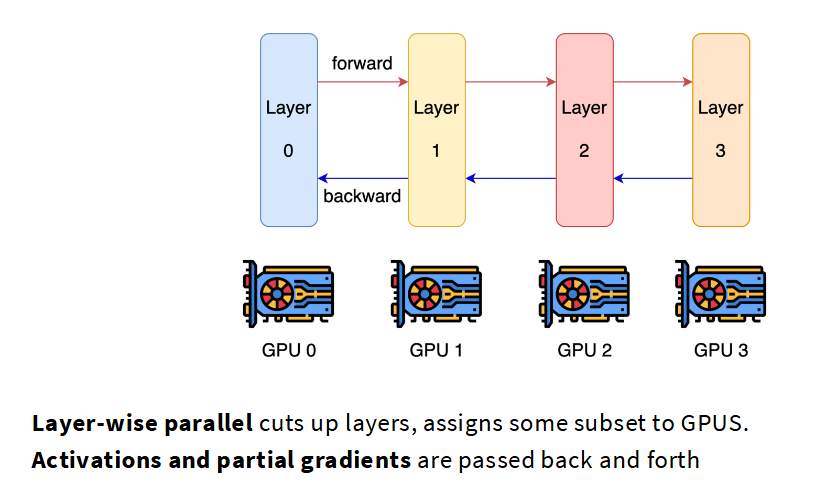
但是这种方法有致命的缺点：**对于GPU的利用率很低，大部分时间都是空闲的**
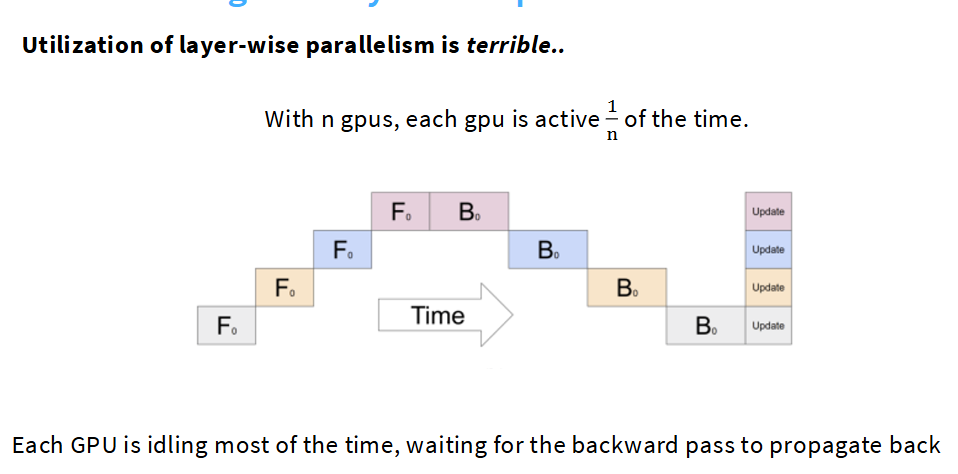

### solution: pipeline parallel
每一个机器处理四个被切分的样本：**batch size是宝贵的资源**
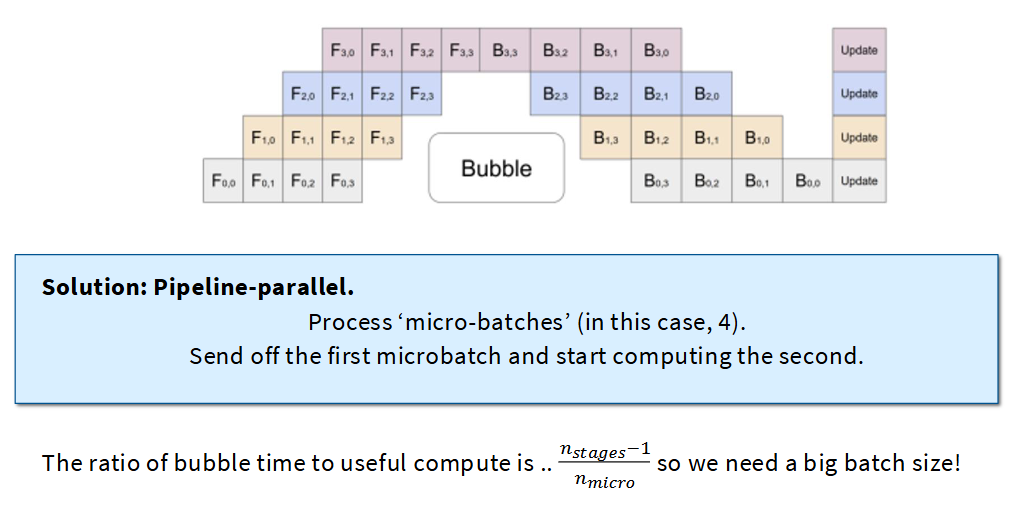
**batch size如果够大，pipeline就可以性能很好,但是其实我们并没有很大的batch size**
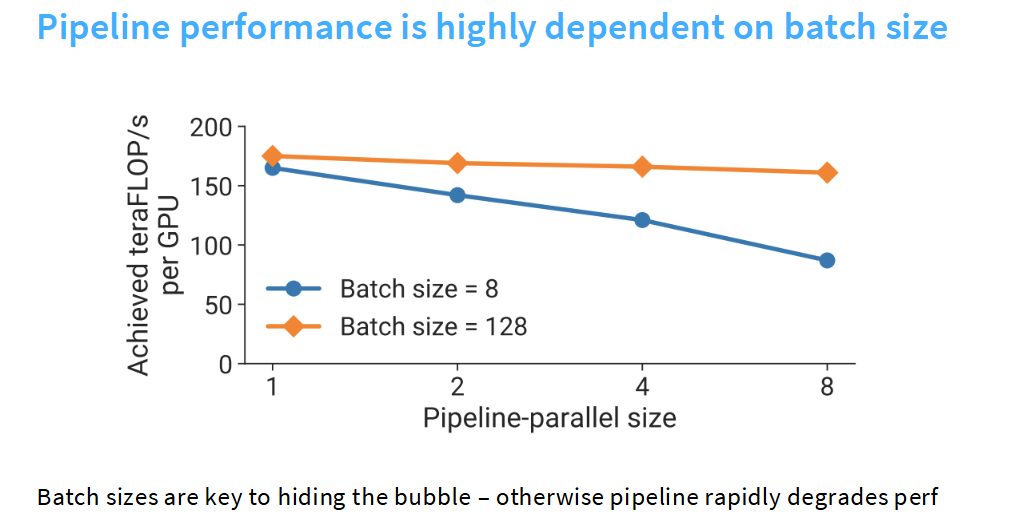
#### 为什么还要使用流水线并行？
尽管存在气泡时间，但流水线并行有其独特的优势，使其成为训练超大模型的关键：

 - 节省内存

    相比于数据并行（DDP），每个GPU只存储模型的一部分（例如，几层）。

    这大大减少了单个GPU上的参数内存。

    此外，它还显著减少了激活值的内存开销，因为每个GPU只需要保存其负责的那些层的激活值，而无需保存整个模型的所有激活值。这是 ZeRO-3 无法解决的问题。

 - 通信特性良好

    相比于 ZeRO-3 (FSDP)，流水线并行的通信开销通常更低，且具有更好的扩展性。

    通信内容: 它只在阶段之间传输激活值。激活值的大小是 b×s×h（微批次大小 b × 序列长度 s × 隐藏层维度 h），这个大小通常比完整的模型参数小得多。

    通信模式: 它使用点对点（point-to-point）通信。每个GPU只需要与上一个和下一个GPU通信，而不是与所有GPU进行All-Gather或All-Reduce这类集体通信操作。集体通信操作在大规模集群（GPU数量多）时容易成为瓶颈。


将多个阶段分配给一个设备
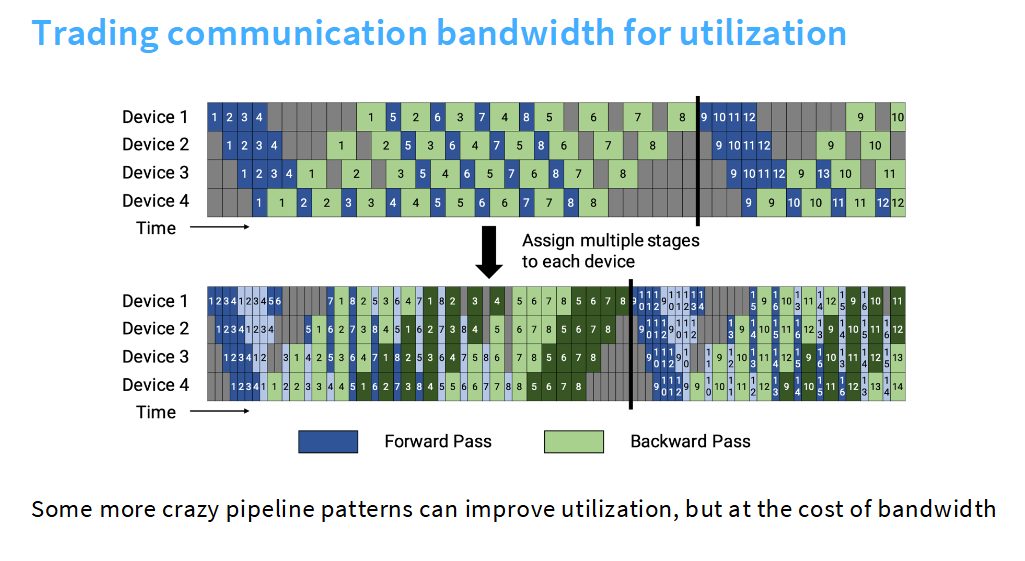

顶部图: 这是一个标准的流水线并行，每个设备（Device 1-4）只负责一个阶段（Stage），可以看到明显的“气泡”时间，即在流水线开始和结束时，许多设备处于空闲状态。

底部图: 通过将多个阶段分配给一个设备，可以更有效地利用每个设备。例如，Device 1 同时负责两个阶段的计算。

这样做的好处是提高了计算资源的利用率。当一个设备完成其第一个阶段的计算后，它不需要等待下一个设备空闲，可以直接开始处理其分配的下一个阶段，从而减少了空闲时间。

这样做的代价是牺牲了通信带宽。一个设备现在需要与更多的设备进行通信，或者在内部进行更多的数据传输。这是一种通信带宽与计算利用率之间的权衡。

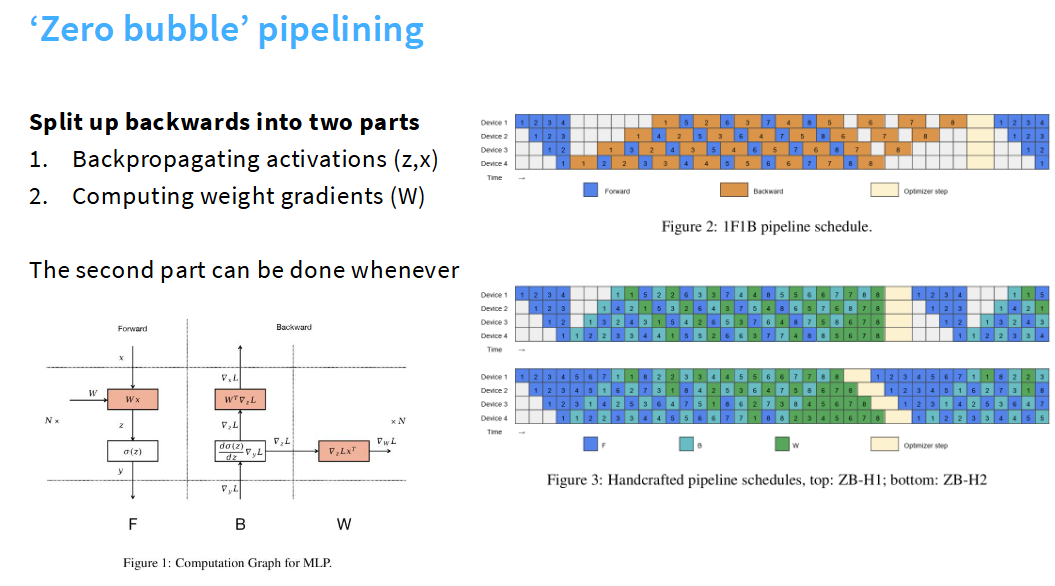
 - 核心思想: **将反向传播（Backward Pass）拆分为两个独立的部分**：

    反向传播激活值（Backpropagating activations）: 计算关于前一层的激活值的梯度。

    计算权重梯度（Computing weight gradients）: 计算关于模型权重的梯度。

 - 图示解释:

    Figure 1 (Computation Graph): 展示了这种拆分在计算图上的体现。在前向传播（F）之后，反向传播（B）被分成了两个子任务。

    Figure 2 (1F1B): 这是一个传统的流水线调度模式（1 Forward, 1 Backward），可以看到前向传播和反向传播之间有明显的“气泡”或空闲时间。

    Figure 3 (Handcrafted Pipeline Schedules):

顶部 ZB-H1: 这是一种“零气泡”（Zero-Bubble）调度，它通过交错前向和反向传播来消除气泡。当第一个设备的前向传播完成，并将激活值发送给下一个设备后，它不会空闲，而是立即开始第一个微批次的反向传播。

底部 ZB-H2: 这是一种更复杂的调度，它进一步细化了任务安排，使得每个时间步都有任务在执行，理论上实现了100% 的计算利用率。

 - pipeline parallel是沿着深度进行切分
 - model（Tensor） parallele是沿着宽度进行切分
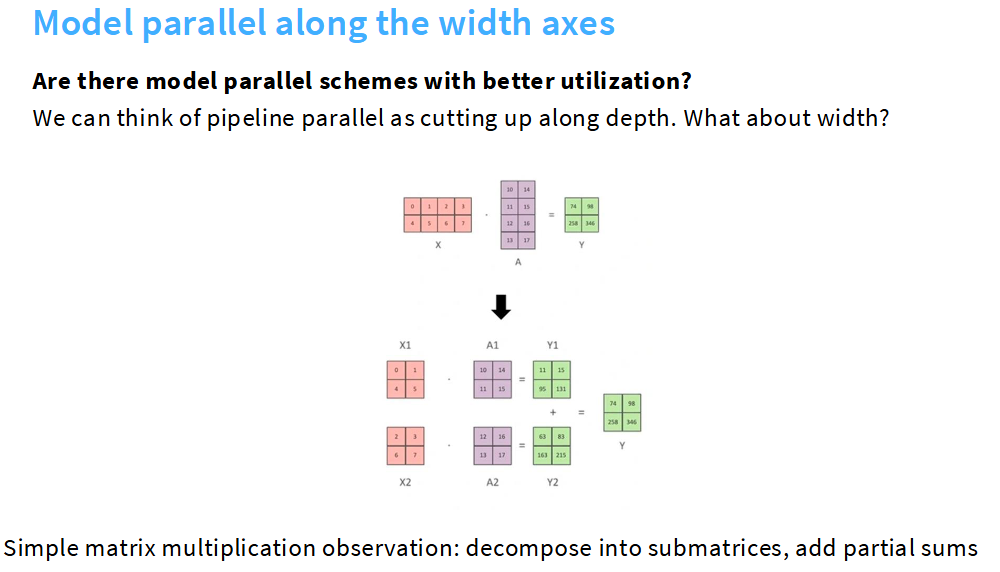

**一个例子**
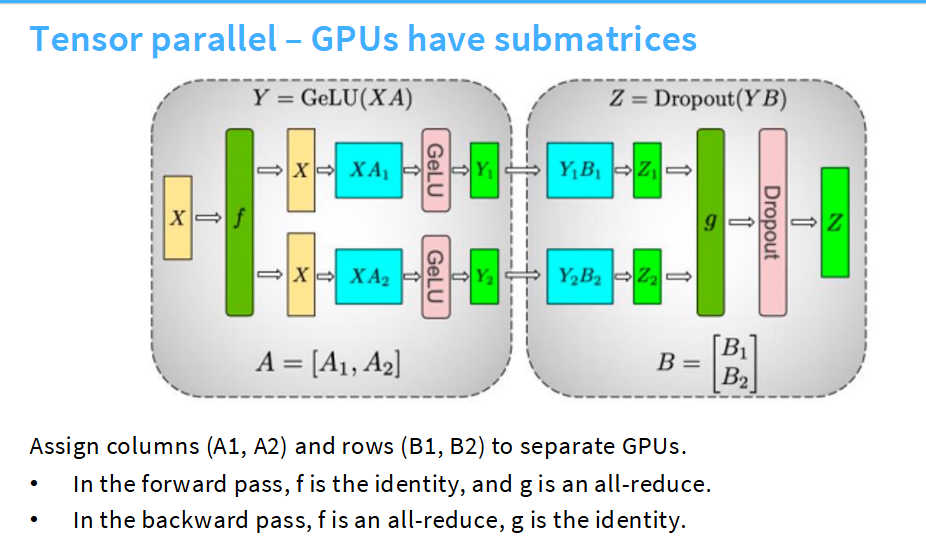

### Tensor parallel需要很快的内部通信
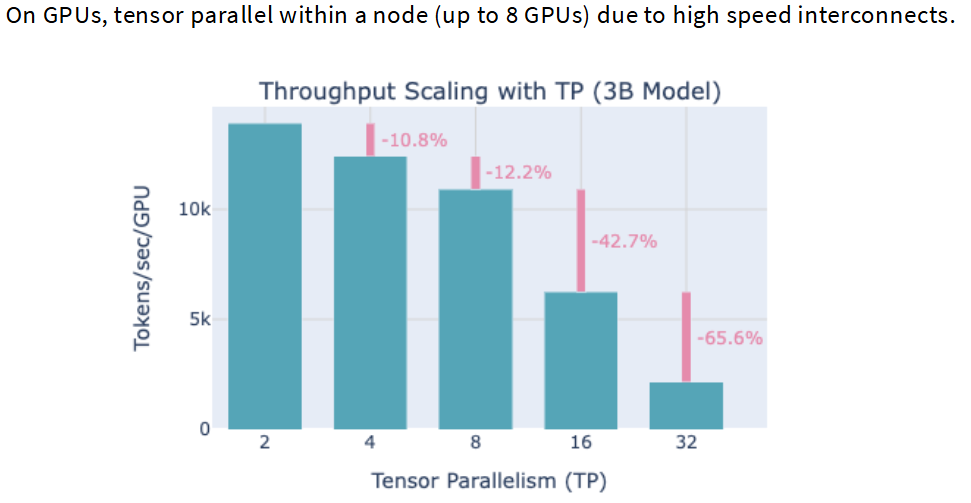
在大于8的之后性能会下降（只有在8以内才会在一个node里面，GPU可以实现快速通信）



### 优缺点
**张量并行的优点 (Pros)**
 - 无气泡（No bubble）: 这是张量并行最大的优势。在张量并行中，所有GPU是同步执行的，每一步计算都依赖于所有GPU的通信结果。因此，它不像流水线并行那样存在启动和结束时的空闲气泡时间。只要网络速度足够快，GPU就可以一直保持忙碌。

 - 低复杂度（Low complexity）: 从实现的抽象角度来看，张量并行通常比流水线并行更简单。开发者可以通过封装（wrap）模型的某一层或某一个模块来应用张量并行，而不需要对整个模型的基础架构进行大的改动。

 - 不依赖大批次（Doesn't need large batch sizes）: 流水线并行为了减少气泡时间，需要将整个批次切分成大量的微批次，从而要求总批次大小足够大。而张量并行没有这个要求，它在较小的批次大小下也能高效工作。

**张量并行的缺点 (Cons)**
 - 通信量大得多（much larger communication）: 这是张量并行最主要的劣势。

 - 流水线并行: 每次通信只传输激活值，大小为 b×s×h（微批次大小 × 序列长度 × 隐藏层维度）。通信模式是点对点（point-to-point），只在相邻的GPU之间发生，通信量相对较小。

 - 张量并行: 每次通信需要传输8倍的激活值数据，并且通信模式是all-reduce。这表示通信量会随着设备数量的增加而显著增加。这是因为它需要在所有参与的GPU之间进行同步，而不是像流水线并行那样只与前后节点通信。

**张量并行是一种用通信带宽换取计算利用率的策略。**

应用场景: 张量并行特别适用于拥有低延迟、高带宽互连的场景，比如单个节点内的多块GPU（如通过 NVLink 连接的8块 GPU）。在这种环境下，巨大的通信开销可以被高速网络有效掩盖，从而实现接近完美的计算扩展性。

与流水线并行结合: 这两种技术通常被结合使用。在节点内部，使用张量并行来最大化单节点内的计算效率。在节点之间，使用流水线并行来解决跨节点通信的瓶颈，因为它对网络带宽的要求更低。这种2D 并行策略是训练万亿参数模型的常见做法。

### activation才是占用内存的罪魁祸首
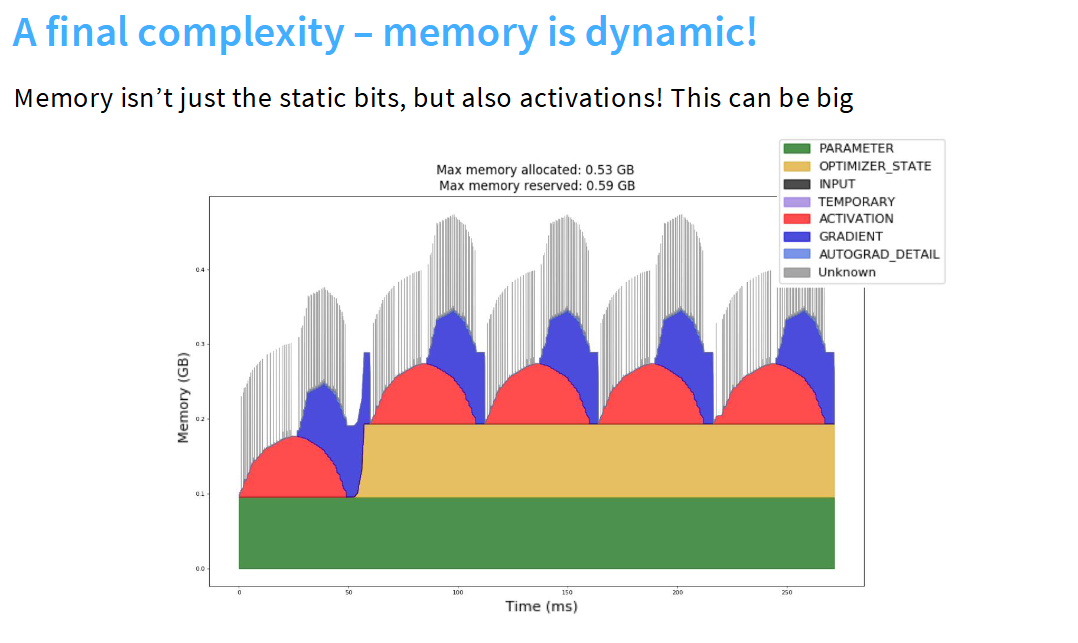

activation并不能像其他参数一样并行
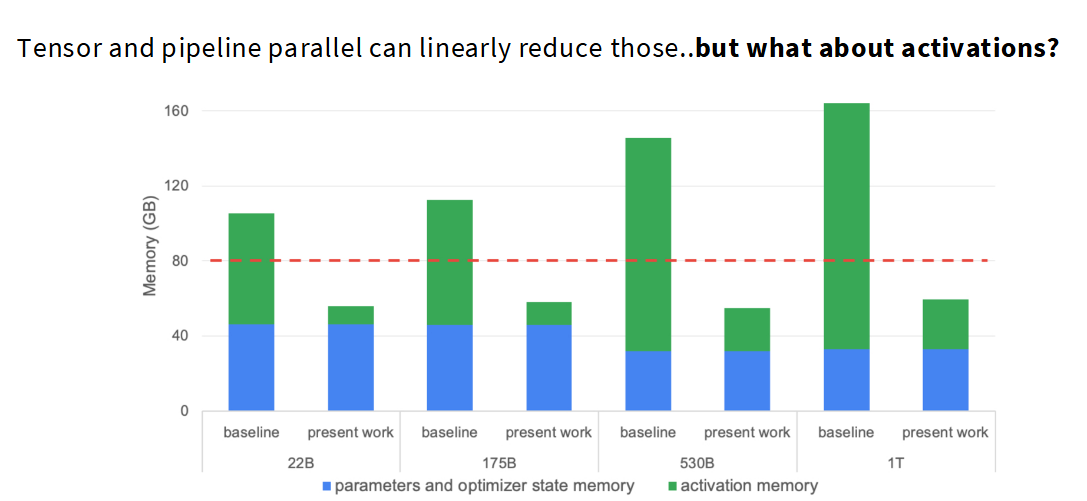



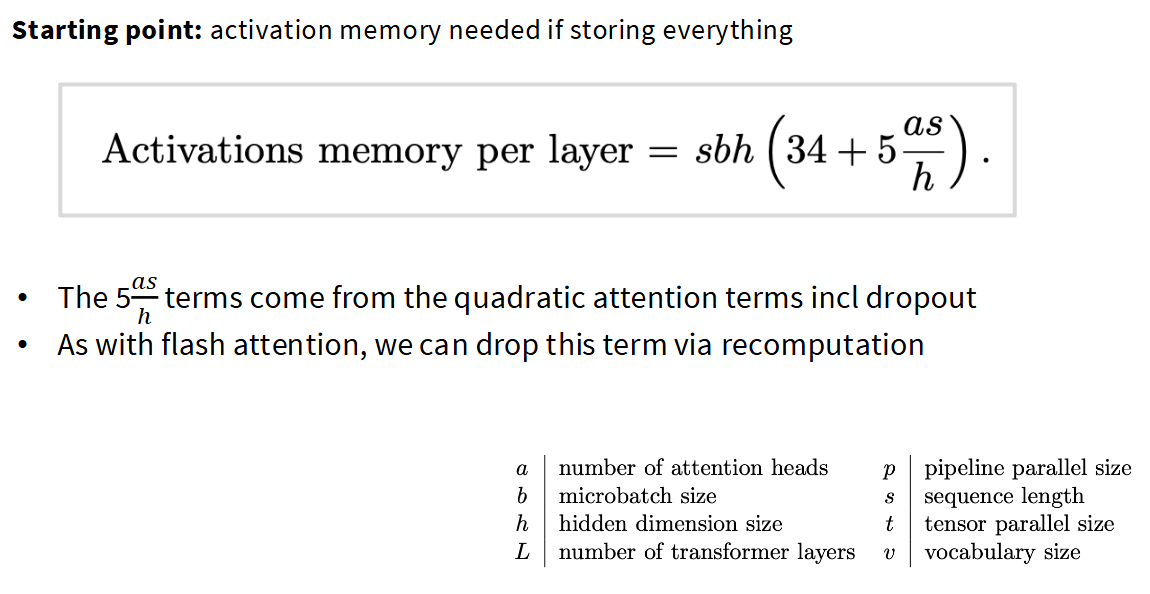
**经过tensor flow的变化**
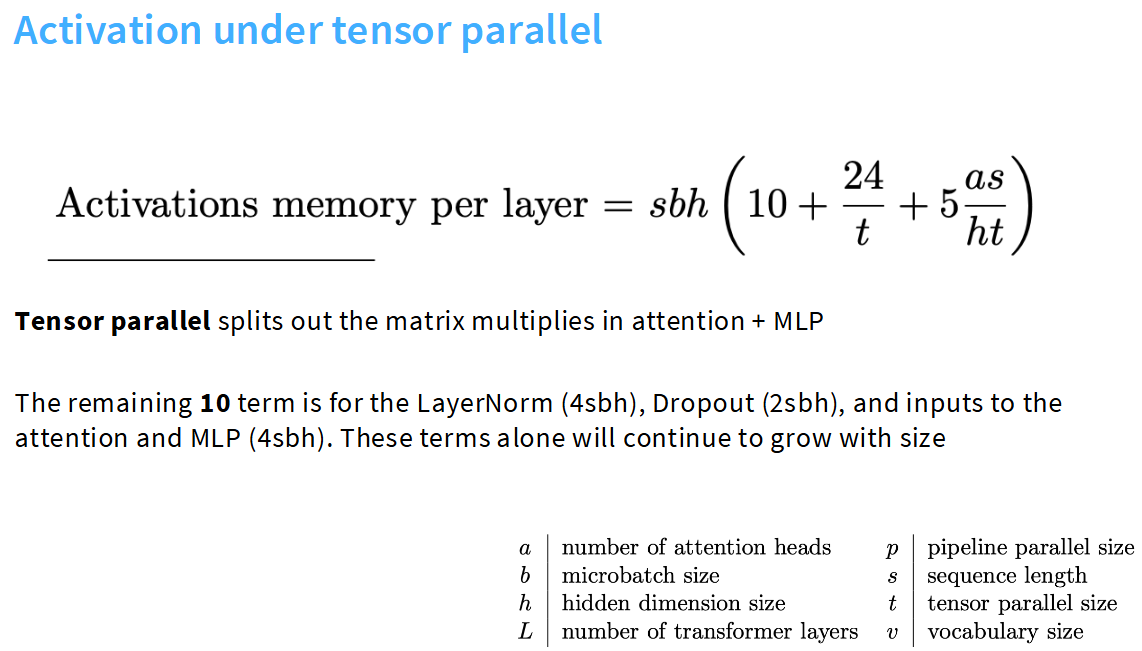

### 剩下的10sbh的优化并行
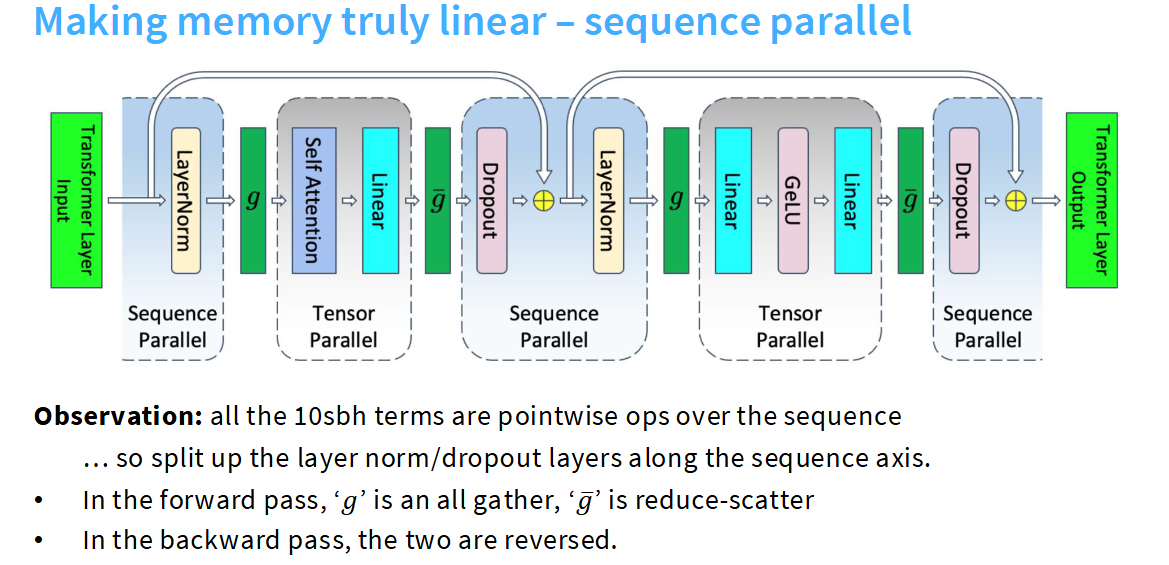
序列并行如何工作？
核心思想：沿着序列的维度（Sequence Axis）对逐点操作进行切分。

图示解释：

输入（Transformer Layer Input）: 输入序列首先被切分，分配给不同的设备。

序列并行模块（Sequence Parallel）: 在 LayerNorm 和 Dropout 模块中，每个设备只处理自己负责的那部分序列数据。

张量并行模块（Tensor Parallel）: 当数据流经**自注意力（Self Attention）和前馈网络（Linear）**模块时，这些操作像我们之前讨论的那样，通过张量并行进行切分和处理。

通信（g 和 $\bar{g}$）:

在前向传播中，在进入张量并行模块之前，需要进行一次**all-gather**操作（图中的 g），将切分在不同设备上的数据拼接成完整的张量，以便进行张量并行计算。

在离开张量并行模块后，需要进行一次**reduce-scatter**操作（图中的 $\bar{g}$），将结果重新切分并发送到对应的设备上，以便进行后续的逐点计算。

在反向传播中，这两个操作的作用是相反的。

### 最终的方案的性能
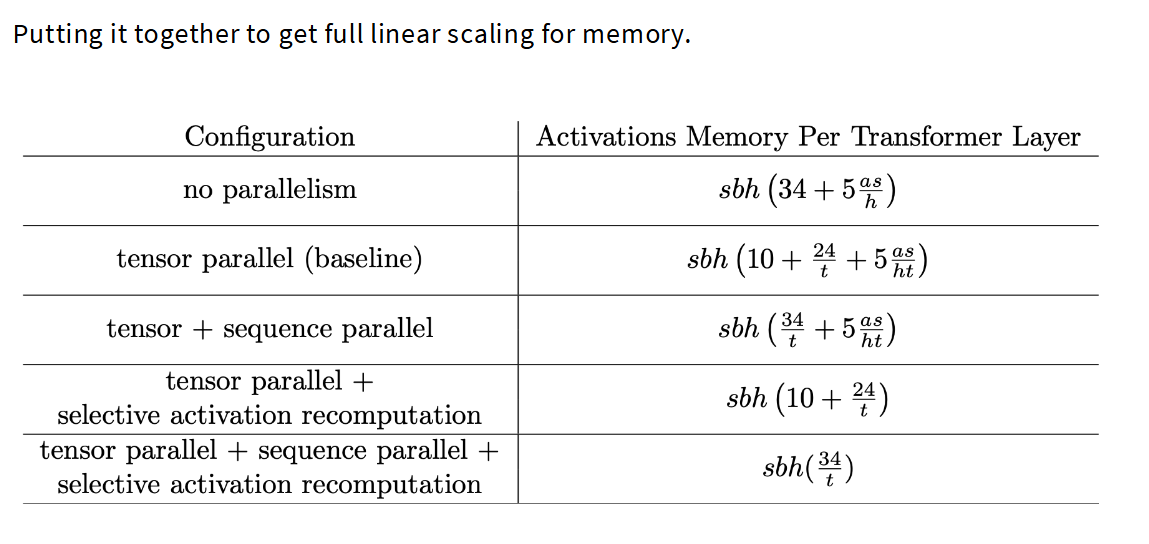

### 其他一些策略
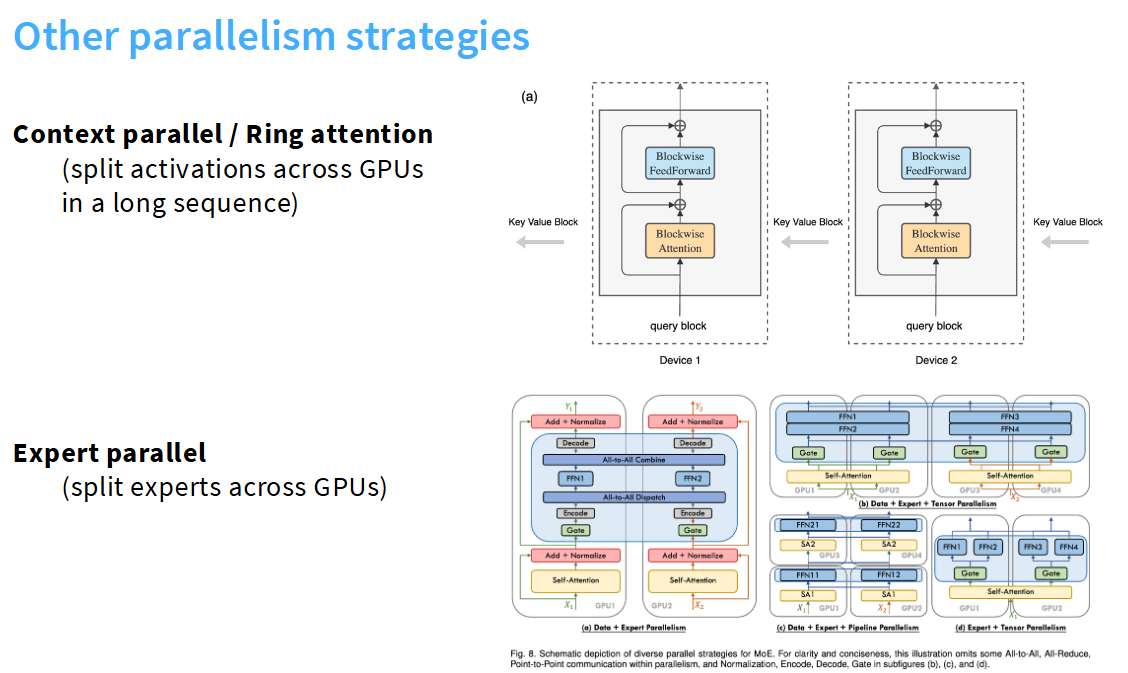

## 最终总结
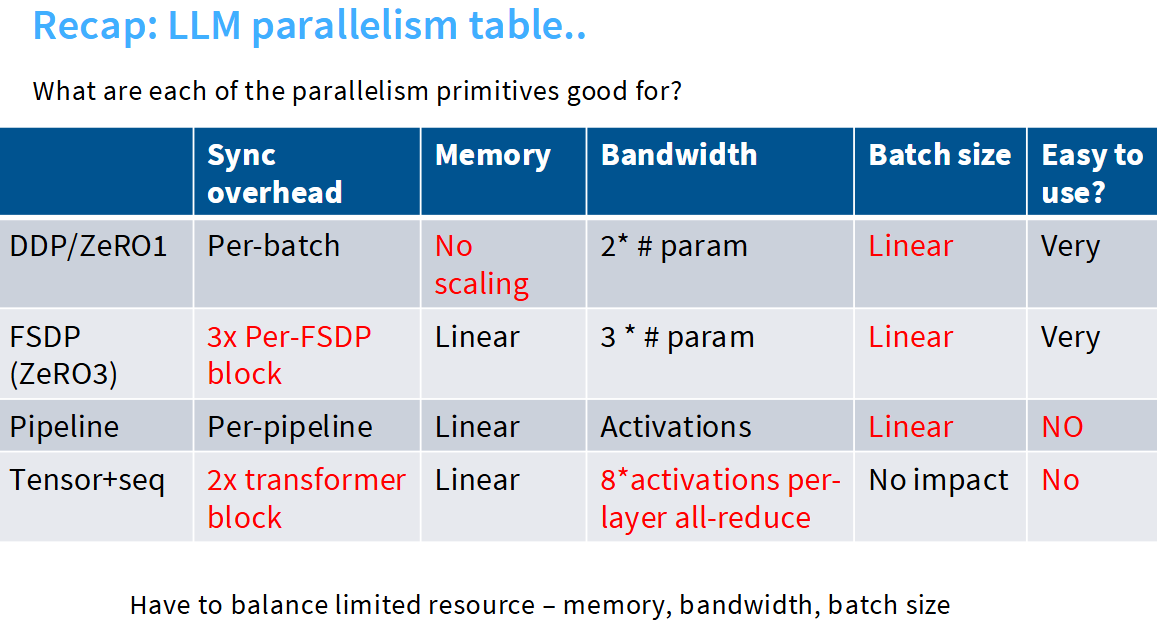

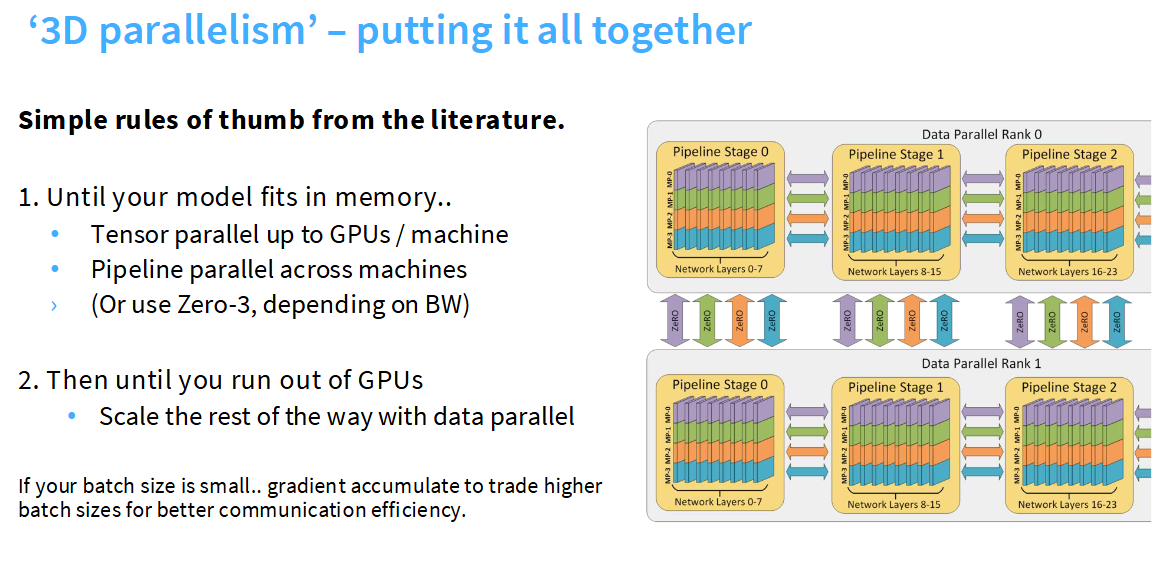

1. 解决内存问题：首先让模型装进显存
这是最关键的第一步。在模型能够被所有 GPU 容纳之前，你需要使用最适合的模型并行技术来切分模型：

张量并行（Tensor Parallel）: 在一台机器内的 GPU 之间使用。这通常是最先采用的方法，因为单机内的高速互连（如 NVLink）能高效处理张量并行所需的大量通信，以解决单卡显存不足的问题。

流水线并行（Pipeline Parallel）: 在多台机器之间使用。当模型的内存需求超过单台机器（通常是8个GPU）所能提供的总显存时，就需要将模型本身切分到多台机器上。流水线并行是跨机器的首选，因为它主要依赖于点对点通信，对网络带宽要求较低，特别适合节点间的慢速网络。

或者使用 ZeRO-3（FSDP）: 如果你的节点间网络带宽（BW）足够高，你也可以选择使用 ZeRO-3 来切分参数，而不是流水线并行。这是因为 ZeRO-3 的通信是集体通信（All-Gather），需要很高的网络带宽来避免成为瓶颈。

2. 解决扩展性问题：用数据并行扩展到所有 GPU
一旦你的模型能够被所有 GPU 容纳（即模型状态的内存需求小于所有 GPU 显存之和），接下来就可以使用数据并行来扩展训练，充分利用集群中的所有计算资源。

数据并行（Data Parallel）：将训练数据切分到不同的模型副本上，通过同步梯度来更新模型。这是最简单、最有效的并行方式，只要模型能装进显存，数据并行就能高效地扩展训练。

ZeRO 的角色：在这个阶段，ZeRO（特别是 ZeRO Stage 1 和 2）可以作为数据并行的增强版。即使你的模型在裸数据并行下能装进显存，使用 ZeRO 仍能通过分片优化器状态和梯度来进一步节省内存，从而让你使用更大的批次大小。

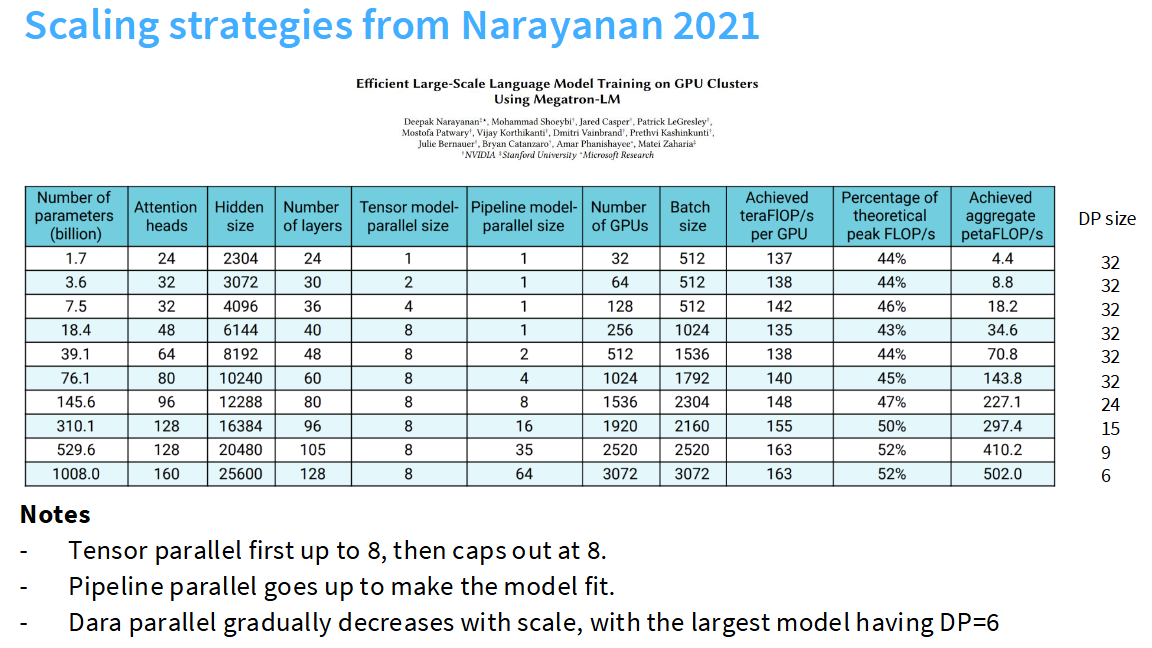

### 在反向传播中的重计算可以有效提升性能
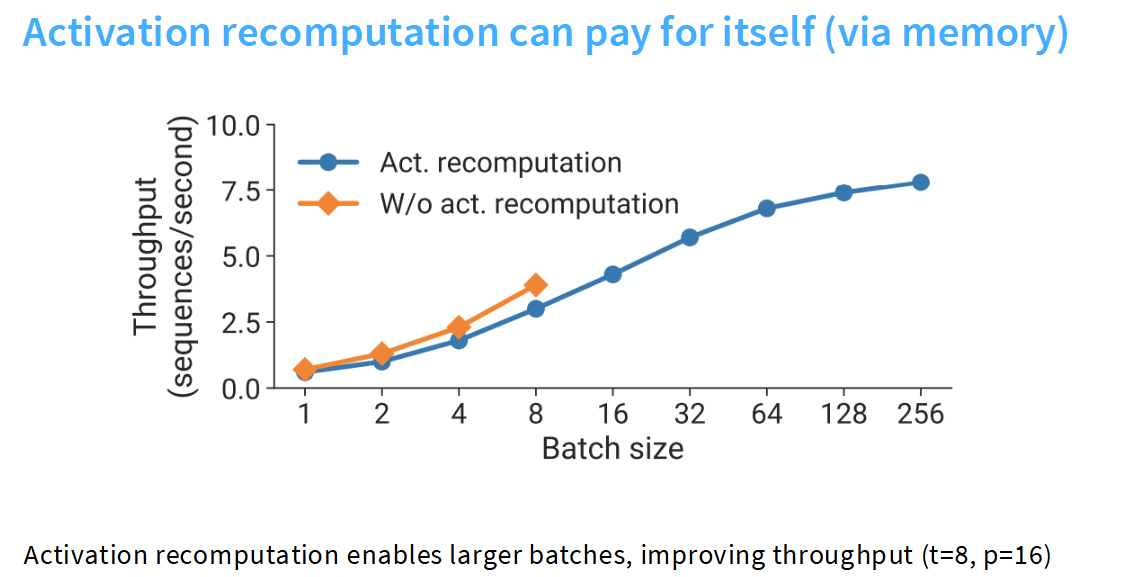

### 使用好的策略可以得到非常好的性能提升
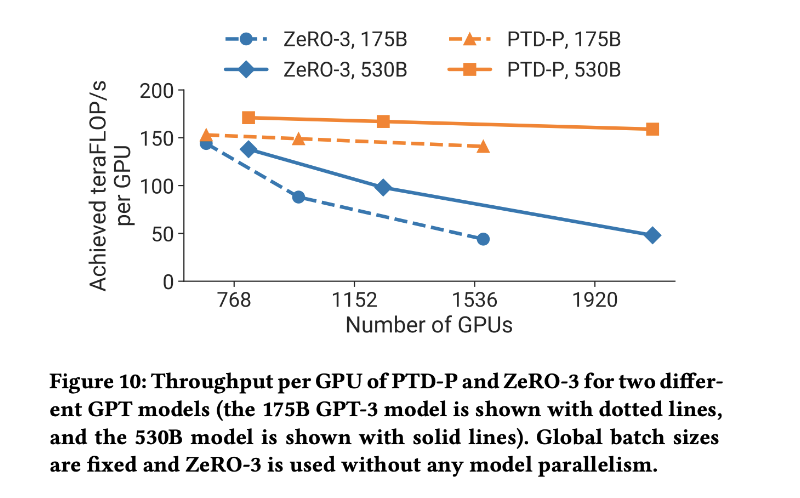